In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
CATEGORY = "Men Tshirts" 
num_attributes = 5
TRAIN_TEST_SPLIT = 0.85
IM_WIDTH = IM_HEIGHT = 384


In [4]:
import os

category_path = CATEGORY.replace(" ", "_")
directory_path = f'/kaggle/input/sorted-train/sorted_images/{category_path}'  # Use CATEGORY here

# Get the list of files in the directory
files = os.listdir(directory_path)

# Filter out directories from the list to count only files
num_files = sum(os.path.isfile(os.path.join(directory_path, file)) for file in files)

print(f"Number of files in the directory for {CATEGORY}: {num_files}")


Number of files in the directory for Men Tshirts: 7267


In [5]:
import pandas as pd

# Load train.csv
def load_data(file_path, category):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Filter for the specified category
    filtered_df = df[df['Category'] == category].copy()
    
    return filtered_df

file_path = '/kaggle/input/visual-taxonomy/train.csv'  # Ensure this path is correct

# Load the filtered data
filtered_data = load_data(file_path, CATEGORY)


In [6]:
# 1. Function to Generate Attribute Names Based on the Number of Attributes
def generate_attributes(num_attributes):
    """
    Generate a list of attribute names based on the specified number of attributes.
    e.g., if num_attributes = 5, it will generate ['attr_1', 'attr_2', ..., 'attr_5']
    """
    return [f'attr_{i+1}' for i in range(num_attributes)]

# 2. Collect Unique Attribute Values Dynamically
def collect_unique_values(df, num_attributes):
    """
    Collect unique attribute values for the specified number of attributes dynamically.
    """
    attributes = generate_attributes(num_attributes)  # Dynamically generate attribute names
    unique_values = {attr: set() for attr in attributes}  # Create a set for each attribute
    
    for attr in attributes:
        if attr in df.columns:  # Ensure the attribute exists in the dataframe
            # Update the set with unique non-null values
            unique_values[attr].update(df[attr].dropna().unique())
    
    return unique_values

# 3. Specify the Number of Attributes You Want to Extract
#num_attributes = 5  # Change this number to the desired number of attributes (up to 10)

# Collect unique values from the filtered data for the specified number of attributes
unique_values = collect_unique_values(filtered_data, num_attributes)

# 4. Print the unique values for verification
print(unique_values)


{'attr_1': {'multicolor', 'default', 'black', 'white'}, 'attr_2': {'polo', 'round'}, 'attr_3': {'printed', 'solid'}, 'attr_4': {'solid', 'default', 'typography'}, 'attr_5': {'short sleeves', 'long sleeves'}}


In [7]:
# Create dataset_dict from unique values
def create_dataset_dict(unique_values, dummy_value='dummy'):
    dataset_dict = {attr: {} for attr in unique_values.keys()}
    
    for attr, values in unique_values.items():
        sorted_values = sorted(values)  # Sort unique values
        for i, value in enumerate(sorted_values):
            dataset_dict[attr][i] = value  # Assign numeric keys
        
        dataset_dict[attr][len(sorted_values)] = dummy_value  # Add dummy value at the end
    
    return dataset_dict

# Create the dataset dictionary
dataset_dict = create_dataset_dict(unique_values)


In [8]:
# Create alias dictionaries
def create_alias_dicts(dataset_dict):
    # Create a new dictionary for alias mappings
    alias_dicts = {}
    
    for attr in dataset_dict.keys():
        # Create alias for each attribute and store in the new dictionary
        alias_dicts[f'{attr}_alias'] = {value: i for i, value in dataset_dict[attr].items()}
    
    # Add the alias dictionaries to the original dataset_dict
    dataset_dict.update(alias_dicts)
    
    return dataset_dict

# Add alias dictionaries to dataset_dict
dataset_dict = create_alias_dicts(dataset_dict)

# Print dataset_dict to verify the mappings
print(dataset_dict)


{'attr_1': {0: 'black', 1: 'default', 2: 'multicolor', 3: 'white', 4: 'dummy'}, 'attr_2': {0: 'polo', 1: 'round', 2: 'dummy'}, 'attr_3': {0: 'printed', 1: 'solid', 2: 'dummy'}, 'attr_4': {0: 'default', 1: 'solid', 2: 'typography', 3: 'dummy'}, 'attr_5': {0: 'long sleeves', 1: 'short sleeves', 2: 'dummy'}, 'attr_1_alias': {'black': 0, 'default': 1, 'multicolor': 2, 'white': 3, 'dummy': 4}, 'attr_2_alias': {'polo': 0, 'round': 1, 'dummy': 2}, 'attr_3_alias': {'printed': 0, 'solid': 1, 'dummy': 2}, 'attr_4_alias': {'default': 0, 'solid': 1, 'typography': 2, 'dummy': 3}, 'attr_5_alias': {'long sleeves': 0, 'short sleeves': 1, 'dummy': 2}}


In [9]:
import numpy as np 
import pandas as pd
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Function to Generate Attribute Names Dynamically Based on the Number of Attributes
def generate_attributes(num_attributes):
    """
    Generate a list of attribute names based on the specified number of attributes.
    e.g., if num_attributes = 5, it will generate ['attr_1', 'attr_2', ..., 'attr_5']
    """
    return [f'attr_{i+1}' for i in range(num_attributes)]

# 2. Main Function to Parse Dataset
def parse_dataset(dataset_path, csv_path, category, num_attributes, ext='jpg', dummy_value='dummy', max_id=70378):
    """
    Extract dataset information based on the specified category, checking IDs from 0 to max_id.
    Skips images whose IDs are not in the CSV.
    Assigns dummy values only to missing attributes for found IDs.
    Dynamically handles up to the specified number of attributes.
    """
    # Load the CSV file
    df_csv = pd.read_csv(csv_path)
    
    # Replace any null values with the dummy value for attributes
    df_csv.fillna(dummy_value, inplace=True)

    # Filter by the specified category (e.g., 'Men Tshirts')
    df_csv = df_csv[df_csv['Category'] == category]
    
    # Convert the 'id' column to int to ensure it matches the image ID format
    df_csv['id'] = df_csv['id'].astype(int)

    # Generate the list of attribute names based on the number of attributes
    attributes = generate_attributes(num_attributes)

    # Helper function to parse information for a single image ID
    def parse_info_for_id(image_id):
        if image_id in df_csv['id'].values:
            row = df_csv[df_csv['id'] == image_id].iloc[0]
            # Return attribute values dynamically
            return tuple(row[attr] for attr in attributes)
        else:
            # Skip IDs that are not found in the CSV (return None to skip)
            return None
    
    # Initialize records list to store data
    records = []
    
    # Iterate over the range of IDs from 0 to max_id (70378)
    for image_id in range(0, max_id + 1):
        result = parse_info_for_id(image_id)
        if result is not None:
            records.append((*result, f"{dataset_path}/{str(image_id).zfill(6)}.{ext}"))  # Add the file path

    # Create DataFrame from the collected records
    df = pd.DataFrame(records, columns=[*attributes, 'file'])

    return df

# Example usage
dataset_folder_name = f'/kaggle/input/sorted-train/sorted_images/{category_path}'
csv_file_path = '/kaggle/input/visual-taxonomy/train.csv'
category = CATEGORY


# Parse the dataset
df = parse_dataset(dataset_folder_name, csv_file_path, category, num_attributes)
column_names = [f'attr{i+1}' for i in range(num_attributes)] + ['file']
df.columns = column_names
print(df.head())


        attr1  attr2    attr3    attr4          attr5  \
0     default  round  printed  default  short sleeves   
1  multicolor   polo    solid    solid  short sleeves   
2     default   polo    solid    solid  short sleeves   
3  multicolor   polo    solid    solid  short sleeves   
4  multicolor   polo    solid    solid  short sleeves   

                                                file  
0  /kaggle/input/sorted-train/sorted_images/Men_T...  
1  /kaggle/input/sorted-train/sorted_images/Men_T...  
2  /kaggle/input/sorted-train/sorted_images/Men_T...  
3  /kaggle/input/sorted-train/sorted_images/Men_T...  
4  /kaggle/input/sorted-train/sorted_images/Men_T...  


In [10]:
# Get the shape of the DataFrame
df_size = df.shape

# Print the number of rows and columns
print(f"The DataFrame has {df_size[0]} rows and {df_size[1]} columns.")


The DataFrame has 7267 rows and 6 columns.


In [11]:
import matplotlib.pyplot as plt

# Function to plot distribution of a pandas series using Matplotlib
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()

    # Create a pie chart using Matplotlib
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    
    # Add a title to the plot
    plt.title(f'Distribution for {pd_series.name}')
    
    # Display the pie chart
    plt.show()

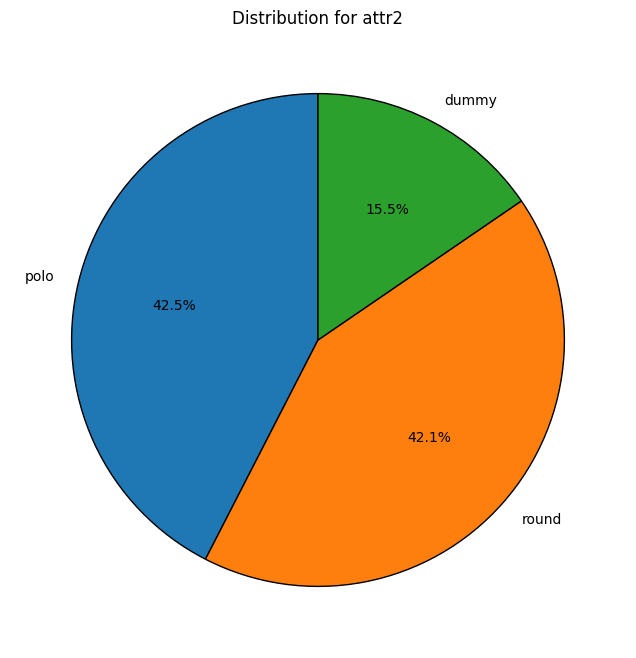

In [12]:
plot_distribution(df['attr2'])

In [13]:
from keras.utils import to_categorical
from PIL import Image
import numpy as np
import pandas as pd

class TrainMDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    Dynamically handles any number of attributes.
    """
    def __init__(self, df, num_attributes):
        self.df = df
        self.num_attributes = num_attributes  # Number of attributes to process dynamically

    def generate_attributes(self):
        """
        Generate a list of attribute names based on the number of attributes.
        e.g., if num_attributes = 5, it will generate ['attr_1', 'attr_2', ..., 'attr_5']
        """
        return [f'attr_{i+1}' for i in range(self.num_attributes)]
    
    def generate_alias_mappings(self):
        """
        Converts alias to id for all attributes dynamically.
        """
        for i in range(1, self.num_attributes + 1):
            attr_alias = f'attr_{i}_alias'
            attr_col = f'attr_{i}'
            self.df[attr_col] = self.df[f'attr{i}'].map(lambda attr: dataset_dict[attr_alias][attr])
    
    def generate_split_indexes(self):
        """
        Generate train, validation, and test indexes based on the dataset split.
        """
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        valid_idx = p[train_up_to:]
   
        
        # Generate alias mappings dynamically for all attributes
        self.generate_alias_mappings()
        
        return train_idx, valid_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        im = im * 2 - 1  # Normalize to -1 to 1
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """

        # Dynamically create arrays to store batched data for all attributes
        images = []
        attr_batches = {f'attr{i+1}s': [] for i in range(self.num_attributes)}

        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                file = person['file']

                # Preprocess the image
                im = self.preprocess_image(file)
                images.append(im)

                # Convert attributes to categorical and append them to respective lists dynamically
                for i in range(1, self.num_attributes + 1):
                    attr_col = f'attr_{i}'
                    attr_value = person[attr_col]
                    attr_batches[f'attr{i}s'].append(to_categorical(attr_value, len(dataset_dict[attr_col])))

                # Yielding condition
                if len(images) >= batch_size:
                    # Prepare the list of categorical attribute arrays
                    attr_outputs = [np.array(attr_batches[f'attr{i}s']) for i in range(1, self.num_attributes + 1)]
                    # Yield a tuple of (input batch, label batch) where each label batch is a list of arrays
                    yield np.array(images), tuple(attr_outputs)

                    # Reset the lists for the next batch
                    images = []
                    attr_batches = {f'attr{i+1}s': [] for i in range(self.num_attributes)}

            # If not training (e.g., in validation or testing), exit after one pass
            if not is_training:
                break

# Example usage
data_generator = TrainMDataGenerator(df, num_attributes)  # Adjust num_attributes as needed (up to 10)
train_idx, valid_idx = data_generator.generate_split_indexes()


In [14]:
from keras.applications import EfficientNetV2L
from keras.optimizers import AdamW
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
import pickle

# Define initial learning rate and epochs
init_lr = 0.00003
epochs = 100

# AdamW optimizer
opt = AdamW(learning_rate=init_lr)

# Define the number of attributes and base weight
base_weight = 1.0  # Minimum weight for the attribute with the least unique values
max_weight = 3.0   # Maximum weight for the attribute with the most unique values

# Define a list of attribute names
attr_names = [f'attr{i+1}_output' for i in range(num_attributes)]

# Define a dictionary of unique values count for each attribute
unique_values_count = {f'attr_{i+1}': len(dataset_dict[f'attr_{i+1}_alias']) for i in range(num_attributes)}
max_unique_count = max(unique_values_count.values())

# Calculate total sum of unique values for normalization
total_unique_values = sum(unique_values_count.values())

# Assign weights based on unique values proportion with scaling
loss_weights_dict = {
    name: 1.5 # Scale from 2 to 15 unique values
    for name in attr_names
}

# Clip weights to ensure they don't exceed max_weight


# Custom loss function to ignore the last class
def custom_loss_function(y_true, y_pred):
    # Exclude the last class (dummy) from the loss calculation
    y_true = tf.cast(y_true[:, :-1], tf.float32)  # Exclude last class
    y_pred = y_pred[:, :-1]  # Exclude last class
    loss = tf.keras.backend.categorical_crossentropy(y_true, y_pred)  # Use tf.keras.backend
    return loss

# Define loss functions and metrics dynamically
loss_dict = {name: custom_loss_function for name in attr_names}
metrics_dict = {name: 'accuracy' for name in attr_names}

# Build EfficientNet V2S model
def build_efficientnetv2s_model(num_attributes):
    base_model = EfficientNetV2L(input_shape=(IM_HEIGHT, IM_WIDTH, 3), include_top=False, weights='imagenet')
    base_model.trainable = True  # Keep all layers unfrozen
    
    inputs = base_model.input
    x = base_model.output

    # Create branches for each attribute
    branches = []
    for i in range(num_attributes):
        num_outputs = unique_values_count[f'attr_{i+1}']  # Get number of outputs for the current attribute
        x_branch = GlobalAveragePooling2D()(x)  # Add Global Average Pooling for each branch
        
        x_branch = Dropout(0.5)(x_branch)              # Dropout layer
        x_branch = Dense(num_outputs, activation='softmax', name=f'attr{i+1}_output')(x_branch)  # Output layer
        branches.append(x_branch)

    model = Model(inputs=inputs, outputs=branches, name="efficientnetv2s_model")
    return model

model = build_efficientnetv2s_model(num_attributes)

# Compile the model
model.compile(optimizer=opt, 
              loss=loss_dict,
              loss_weights=loss_weights_dict,
              metrics=metrics_dict)

# Callbacks
callbacks = [
    ModelCheckpoint("./model_checkpoint.keras", monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

# Training
batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)


history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx) // batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx) // valid_batch_size)

# Save training history
with open('./training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Output the model summary for verification
model.summary()


473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100


I0000 00:00:1731705831.065086      69 service.cc:145] XLA service 0x7c7b74004330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731705831.065160      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731705831.065166      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-15 21:26:21.702975: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,96,96,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,193,193,32]{3,2,1,0}, f16[128,3,3,32]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-15 21:26:21.984498: E external/local_xla/xla/servi

193/193 ━━━━━━━━━━━━━━━━━━━━ 1183s 2s/step - attr1_output_accuracy: 0.3611 - attr2_output_accuracy: 0.6887 - attr3_output_accuracy: 0.6455 - attr4_output_accuracy: 0.5588 - attr5_output_accuracy: 0.5825 - loss: 3.5650 - val_attr1_output_accuracy: 0.5993 - val_attr2_output_accuracy: 0.8438 - val_attr3_output_accuracy: 0.7721 - val_attr4_output_accuracy: 0.7261 - val_attr5_output_accuracy: 0.8125 - val_loss: 1.5635
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - attr1_output_accuracy: 0.6013 - attr2_output_accuracy: 0.8273 - attr3_output_accuracy: 0.7661 - attr4_output_accuracy: 0.7258 - attr5_output_accuracy: 0.7882 - loss: 1.4339 - val_attr1_output_accuracy: 0.6131 - val_attr2_output_accuracy: 0.8465 - val_attr3_output_accuracy: 0.7730 - val_attr4_output_accuracy: 0.7454 - val_attr5_output_accuracy: 0.8281 - val_loss: 1.3425
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - attr1_output_accuracy: 0.6589 - attr2_output_accuracy: 0.8396 - attr3_output_accuracy: 0.7774 - att

Model: "efficientnetv2s_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 384, 384,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 192, 192,  │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 192, 192,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 192, 192,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 192, 192,  │      9,216 │ stem_activation[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 192, 192,  │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 192, 192,  │          0 │ block1a_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 192, 192,  │          0 │ block1a_project_… │
│                     │ 32)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 192, 192,  │      9,216 │ block1a_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 192, 192,  │        128 │ block1b_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 192, 192,  │          0 │ block1b_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 192, 192,  │          0 │ block1b_project_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 192, 192,  │          0 │ block1b_drop[0][… │
│                     │ 32)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 192, 192,  │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 192, 192,  │        128 │ block1c_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 192, 192,  │          0 │ block1c_project_

 Total params: 352,284,572 (1.31 GB)

 Trainable params: 117,257,330 (447.30 MB)

 Non-trainable params: 512,576 (1.96 MB)

 Optimizer params: 234,514,666 (894.60 MB)